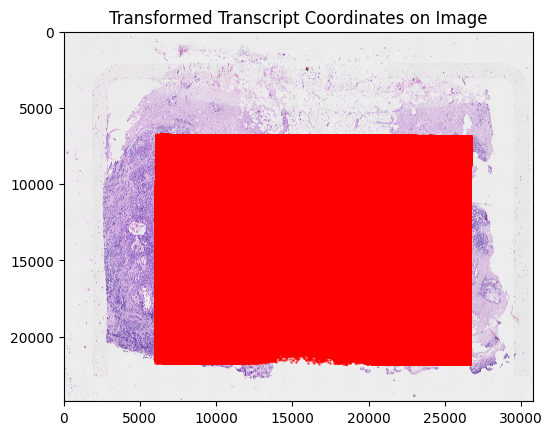

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tifffile import imread

# Load the spatial image
image_path = '../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
img = imread(image_path)

# Load the Xenium data
xenium_data_path = '../data/xenium/outs/transcripts.parquet'
xenium_df = pd.read_parquet(xenium_data_path)

# Define the transformation matrix from the CSV file
transform_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Get the inverse matrix
transform_matrix_inv = np.linalg.inv(transform_matrix)

# Extract coordinates and apply scaling
coords = xenium_df[['x_location', 'y_location']].values
micron_to_pixel = 0.2125  # Microns per pixel
coords_scaled = coords / micron_to_pixel

# Function to transform coordinates
def transform_coordinates(coords, transform_matrix):
    coords = np.hstack((coords, np.ones((len(coords), 1))))
    transformed_coords = np.dot(transform_matrix, coords.T).T
    # Return only the x and y coordinates
    return transformed_coords[:, :2]

# Apply the transformation to the scaled coordinates
transformed_coords = transform_coordinates(coords_scaled, transform_matrix_inv)

# Update the DataFrame with the transformed coordinates
xenium_df[['x_location_transformed', 'y_location_transformed']] = transformed_coords

# Visualize the transformed coordinates over the image
plt.imshow(img, cmap='gray')
plt.scatter(xenium_df['x_location_transformed'], xenium_df['y_location_transformed'], s=1, alpha=0.5, c='red')
plt.title('Transformed Transcript Coordinates on Image')
plt.show()


In [63]:
xenium_df

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,x_location_transformed,y_location_transformed
0,281474976710656,565,0,b'SEC11C',4.395842,328.666473,12.019493,18.662479,5981.804361,20855.340013
1,281474976710657,540,0,b'NegControlCodeword_0502',5.074415,236.964844,7.608510,18.634956,5982.441069,21107.335432
2,281474976710658,562,0,b'SEC11C',4.702023,322.797150,12.289083,18.662479,5982.567120,20871.472398
3,281474976710659,271,0,b'DAPK3',4.906601,581.428650,11.222615,20.821745,5986.592507,20160.783340
4,281474976710660,291,0,b'TCIM',5.660699,720.851746,9.265523,18.017488,5990.531645,19777.673639
...,...,...,...,...,...,...,...,...,...,...
42638078,281805689407068,-1,0,b'HOXD8',5218.000488,5295.519531,30.560934,20.061079,20374.743128,7276.769846
42638079,281805689407071,135717,1,b'LUM',5218.804688,4792.928223,38.440426,21.389278,20370.223389,8657.848701
42638080,281805689407078,-1,0,b'LUM',5217.404785,5425.386230,30.519602,21.960102,20374.845524,6919.902408
42638081,281805689407083,-1,0,b'NARS',5220.155273,4839.704102,32.180698,25.970398,20374.560881,8529.330911


In [179]:
min_x = xenium_df['x_location_transformed'].min()
min_y = xenium_df['y_location_transformed'].min()

In [180]:
print(min_x)
print(min_y)

5977.9149682024545
6740.67089637296


In [64]:
micron_to_pixel = 0.2125
bin_size_microns = 2.0
bin_size_pixels = bin_size_microns / micron_to_pixel
bin_size_pixels


9.411764705882353

In [65]:

# example: if coorinate is 5 -> bin 0, if coordinate 30 -> bin 3 (floor division for coordinate/bin_size_pixels)
x_bins = np.floor(transformed_coords[:, 0] / bin_size_pixels).astype(int)
y_bins = np.floor(transformed_coords[:, 1] / bin_size_pixels).astype(int)

# because of the shifted coordinates, we go to 0 and 1
x_bins -= x_bins.min()
y_bins -= y_bins.min()

xenium_df['x_bins'] = x_bins
xenium_df['y_bins'] = y_bins

xenium_df['feature_name'] = xenium_df['feature_name'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

result_df = xenium_df[['x_bins', 'y_bins', 'transcript_id', 'feature_name', 'x_location_transformed', 'y_location_transformed']]

print(result_df.head())


   x_bins  y_bins    transcript_id             feature_name   
0       0    1499  281474976710656                   SEC11C  \
1       0    1526  281474976710657  NegControlCodeword_0502   
2       0    1501  281474976710658                   SEC11C   
3       1    1426  281474976710659                    DAPK3   
4       1    1385  281474976710660                     TCIM   

   x_location_transformed  y_location_transformed  
0             5981.804361            20855.340013  
1             5982.441069            21107.335432  
2             5982.567120            20871.472398  
3             5986.592507            20160.783340  
4             5990.531645            19777.673639  


In [66]:
result_df.to_csv('transcripts_binned.csv', index=False)

In [75]:
import pandas as pd
# Create a 'bin' column that combines x_bins and y_bins as tuples
result_df['bin'] = list(zip(result_df['x_bins'], result_df['y_bins']))

# Create a pivot table
pivot_table = pd.pivot_table(result_df, 
                             index='bin', 
                             columns='feature_name', 
                             aggfunc='size', 
                             fill_value=0)


# Print the resulting matrix
print(pivot_table)


/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_36177/663148751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['bin'] = list(zip(result_df['x_bins'], result_df['y_bins']))


feature_name  ABCC11  ACTA2  ACTG2  ADAM9  ADGRE5  ADH1B  ADIPOQ  AGR3  AHSP   
bin                                                                            
(0, 1376)          0      0      0      0       0      0       0     0     0  \
(0, 1400)          0      1      0      0       0      0       0     0     0   
(0, 1402)          0      0      0      0       0      0       0     0     0   
(0, 1415)          0      0      0      0       0      0       0     0     0   
(0, 1425)          0      0      0      0       0      0       0     0     0   
...              ...    ...    ...    ...     ...    ...     ...   ...   ...   
(2201, 146)        0      0      0      0       0      0       0     0     0   
(2201, 147)        0      0      0      0       0      0       0     0     0   
(2201, 148)        0      0      0      0       0      0       0     0     0   
(2201, 153)        0      0      0      0       0      0       0     0     0   
(2201, 154)        0      0      0      

In [68]:
pivot_table.to_csv('transcripts_binned_hd_style.csv', index=False)

In [69]:
non_zero_rows = pivot_table[(pivot_table > 10).any(axis=1)]

# Display the rows with non-zero values
print(non_zero_rows)


feature_name  ABCC11  ACTA2  ACTG2  ADAM9  ADGRE5  ADH1B  ADIPOQ  AGR3  AHSP   
bin                                                                            
(183, 887)         0      5      0      0       0      0       0     0     0  \
(347, 215)         0      1      0      2       0      0       0     0     0   
(417, 1199)        0      0      1      0       0      0       0     0     0   
(590, 696)         0      2      0      1       0      0       0     0     0   
(610, 748)         0      0      0      0       0      0       0     0     0   
(665, 661)         0      0      0      1       0      0       0     0     0   
(679, 669)         0      1      1      2       0      0       0     0     0   
(763, 716)         0      0      0      1       0      0       0     0     0   
(767, 431)         0      0      0      0       0      0       0     0     0   
(823, 682)         0      4      1      1       0      0       0     0     0   
(848, 804)         0      0      0      

In [76]:
import scanpy as sc
import anndata as ad
import pandas as pd

df = pivot_table

# Extract x_bins and y_bins from the index
df['x_bins'] = [x for x, y in df.index]
df['y_bins'] = [y for x, y in df.index]

# Convert index to string format to avoid the TypeError
df.index = df.index.map(str)

# Create AnnData object
X = df.drop(columns=['x_bins', 'y_bins']).values  # Dropping the new columns for the AnnData matrix
adata = ad.AnnData(X=X)
adata.obsm['spatial'] = df[['x_bins', 'y_bins']].values  # Spatial information, mby do the whole polygon
adata.var_names = df.columns[:-2]  # Setting gene/feature names (excluding the last two columns)
adata.obs_names = df.index.astype(str)  # Ensuring that bin names are strings

# Add metadata
metadata = pd.DataFrame({
    'bin': df.index, # Replace with transcript ids and other dat
})
metadata.set_index('bin', inplace=True)
adata.obs = metadata

# Save AnnData object
adata.write('transcripts_anndata.h5ad')
adata.to_df()


feature_name,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,ADIPOQ,AGR3,AHSP,AIF1,...,ZEB2,ZNF562,antisense_ADCY4,antisense_BCL2L15,antisense_LGI3,antisense_MYLIP,antisense_PROKR2,antisense_SCRIB,antisense_TRMU,antisense_ULK3
bin,,,,,,,,,,,,,,,,,,,,,
"(0, 1376)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1400)",0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1402)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1415)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1425)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2201, 146)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(2201, 147)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(2201, 148)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
import numpy as np
import pandas as pd
import anndata as ad

# Bin size in pixels
bin_size_pixels = 9.411764705882353

# Assuming `adata` is your existing AnnData object
# Extracting the bin indices from the observation index
# Assumes the observation index of adata is in the format (x, y) as a tuple
x_bins = np.array([int(bin.split(', ')[0].strip('(')) for bin in adata.obs.index])
y_bins = np.array([int(bin.split(', ')[1].strip(')')) for bin in adata.obs.index])

# Calculate the start coordinates
start_x = x_bins * bin_size_pixels + min_x
start_y = y_bins * bin_size_pixels + min_y

# Calculate the end coordinates by adding the bin size to the start coordinates
end_x = start_x + bin_size_pixels
end_y = start_y + bin_size_pixels

# Add the start and end coordinates as metadata to the AnnData object
adata.obs['start_x'] = start_x
adata.obs['start_y'] = start_y
adata.obs['end_x'] = end_x
adata.obs['end_y'] = end_y

# Optionally, you can also store the bin size in the AnnData object for future reference
adata.uns['bin_size_pixels'] = bin_size_pixels

# Save the updated AnnData object
adata.write('transcripts_anndata_with_start_end_coords.h5ad')

# Verify the changes
print(adata.obs.head())


           start_x       start_y     end_x         end_y
bin                                                     
(0, 1376)      0.0  12950.588235  9.411765  12960.000000
(0, 1400)      0.0  13176.470588  9.411765  13185.882353
(0, 1402)      0.0  13195.294118  9.411765  13204.705882
(0, 1415)      0.0  13317.647059  9.411765  13327.058824
(0, 1425)      0.0  13411.764706  9.411765  13421.176471


In [89]:
import pandas as pd
import anndata as ad

grouped_transcripts = result_df.groupby('feature_name')['transcript_id'].agg(lambda x: ','.join(map(str, x))).reset_index()
transcript_df = pd.DataFrame(grouped_transcripts).set_index('feature_name')
adata.var['transcript_ids'] = transcript_df['transcript_id']
adata.write('transcripts_anndata_with_var_metadata.h5ad')
print(adata.var.head())


                                                 transcript_ids
feature_name                                                   
ABCC11        281474976881559,281474976881570,28147497688157...
ACTA2         281474976752592,281474976752593,28147497675259...
ACTG2         281474976843797,281474976843800,28147497684381...
ADAM9         281474976816200,281474976816214,28147497681621...
ADGRE5        281474976830613,281474976830670,28147497683069...


In [ ]:

# uns: start with original, downscale an image so we can plot it faster
# sse scaling factors
# scanpy tutorial, play around


In [122]:
adata.write('transcripts_anndata_intermediate.h5ad')

In [123]:
import anndata as ad



# Calculate the center points
adata.obs['center_x'] = (adata.obs['start_x'] + adata.obs['end_x']) / 2
adata.obs['center_y'] = (adata.obs['start_y'] + adata.obs['end_y']) / 2

# Verify that the center points have been added
print(adata.obs.head())


           start_x       start_y     end_x         end_y  center_x   
bin                                                                  
(0, 1376)      0.0  12950.588235  9.411765  12960.000000  4.705882  \
(0, 1400)      0.0  13176.470588  9.411765  13185.882353  4.705882   
(0, 1402)      0.0  13195.294118  9.411765  13204.705882  4.705882   
(0, 1415)      0.0  13317.647059  9.411765  13327.058824  4.705882   
(0, 1425)      0.0  13411.764706  9.411765  13421.176471  4.705882   

               center_y  
bin                      
(0, 1376)  12955.294118  
(0, 1400)  13181.176471  
(0, 1402)  13200.000000  
(0, 1415)  13322.352941  
(0, 1425)  13416.470588  


In [124]:
adata.obsm['spatial'] = np.vstack([adata.obs['center_x'], adata.obs['center_y']]).T

# Step 3: Move the start_x, start_y, end_x, and end_y columns to obsm
adata.obsm['start_x'] = adata.obs['start_x'].values
adata.obsm['start_y'] = adata.obs['start_y'].values
adata.obsm['end_x'] = adata.obs['end_x'].values
adata.obsm['end_y'] = adata.obs['end_y'].values

In [163]:
np.max(adata.obsm['spatial'])

20720.0

In [128]:
adata.obsm

AxisArrays with keys: spatial, start_x, start_y, end_x, end_y

In [138]:
from PIL import Image
import numpy as np
import cv2

image_path = '../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
img = imread(image_path)
print(img.shape)
scaling_factor = 0.17011142 
new_size = (int(img.shape[1] * scaling_factor), int(img.shape[0] * scaling_factor))
print(new_size)
downscaled_image = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)

# Optional: Check the shape of the array to verify the downscaled size
print(downscaled_image.shape)


image_array = np.array(downscaled_image)


(24241, 30786, 3)
(5237, 4123)
(4123, 5237, 3)


In [139]:
import anndata as ad
from collections import OrderedDict

# Assuming adata is your existing AnnData object

# Structure for adding image and scaling factor
adata.uns['spatial'] = OrderedDict({
    'Xenium_FFPE_Human_Breast_Cancer_Rep1': {
        'images': {
            'hires': image_array
        },
        'scalefactors': {
            'tissue_hires_scalef': scaling_factor
        }
    }
})

# Verify the structure
print(adata.uns)


OrderedDict([('spatial', OrderedDict([('Xenium_FFPE_Human_Breast_Cancer_Rep1', {'images': {'hires': array([[[  0,   0,   0],
        [ 74,  74,  74],
        [158, 158, 158],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [112, 112, 112],
        [239, 238, 239],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [112, 112, 112],
        [239, 238, 239],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[239, 238, 239],
        [239, 238, 239],
        [239, 239, 239],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[238, 238, 239],
        [239, 239, 239],
        [239, 239, 239],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[117, 117, 117],
        [117, 117, 117],
        [117

In [144]:
adata.to_df()

feature_name,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,ADIPOQ,AGR3,AHSP,AIF1,...,ZEB2,ZNF562,antisense_ADCY4,antisense_BCL2L15,antisense_LGI3,antisense_MYLIP,antisense_PROKR2,antisense_SCRIB,antisense_TRMU,antisense_ULK3
bin,,,,,,,,,,,,,,,,,,,,,
"(0, 1376)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1400)",0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1402)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1415)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1425)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2201, 146)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(2201, 147)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(2201, 148)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

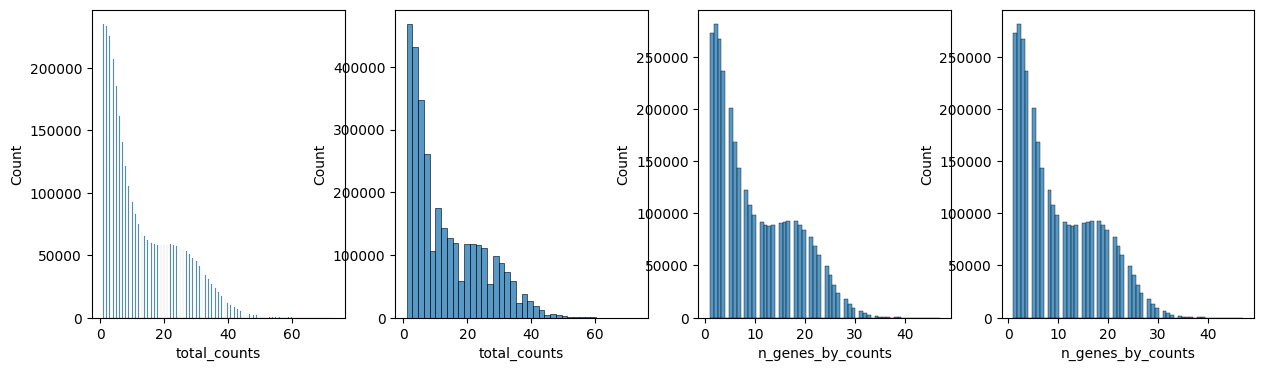

In [146]:
import seaborn as sns
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [152]:
adata.uns['spatial']['Xenium_FFPE_Human_Breast_Cancer_Rep1']['scalefactors']['spot_diameter_fullres'] = bin_size_pixels

In [153]:
adata.uns['spatial']['Xenium_FFPE_Human_Breast_Cancer_Rep1']['scalefactors']['spot_diameter_fullres']

9.411764705882353

In [158]:
adata.uns['spatial']['Xenium_FFPE_Human_Breast_Cancer_Rep1']['scalefactors']

{'tissue_hires_scalef': 0.17011142, 'spot_diameter_fullres': 9.411764705882353}

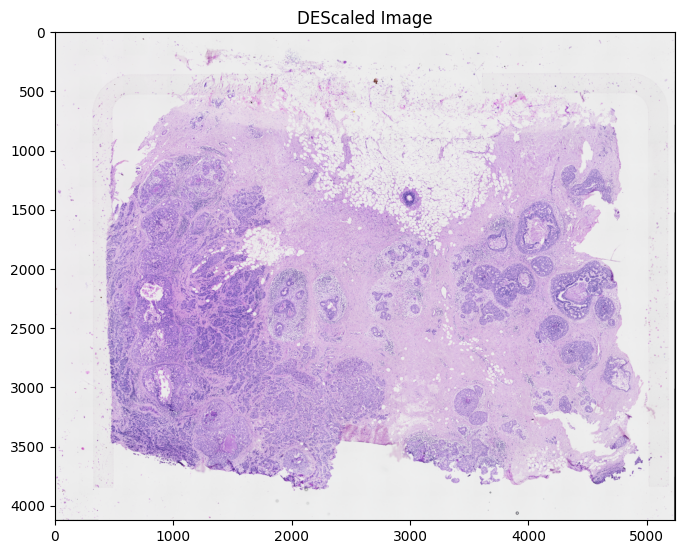

In [165]:
import matplotlib.pyplot as plt
import numpy as np

library_id = 'Xenium_FFPE_Human_Breast_Cancer_Rep1'

descaled_image = adata.uns['spatial'][library_id]['images']['hires']

plt.figure(figsize=(8, 8))
plt.imshow(descaled_image, cmap='gray')
plt.title('DEScaled Image')
plt.show()


In [178]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x12bc4c0e0> (for post_execute):


KeyboardInterrupt: 

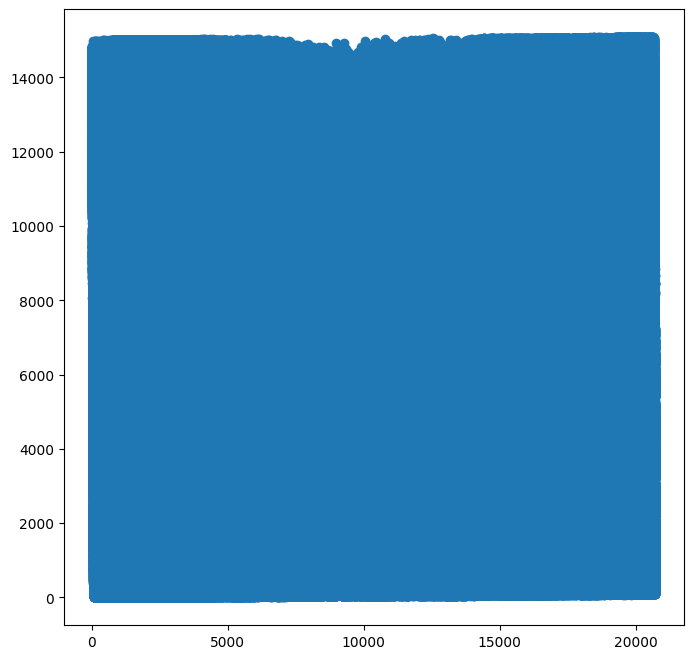

In [176]:
coordinates = adata.obsm['spatial'] 

x = coordinates[:, 0]
y = coordinates[:, 1]
plt.scatter(x,y)

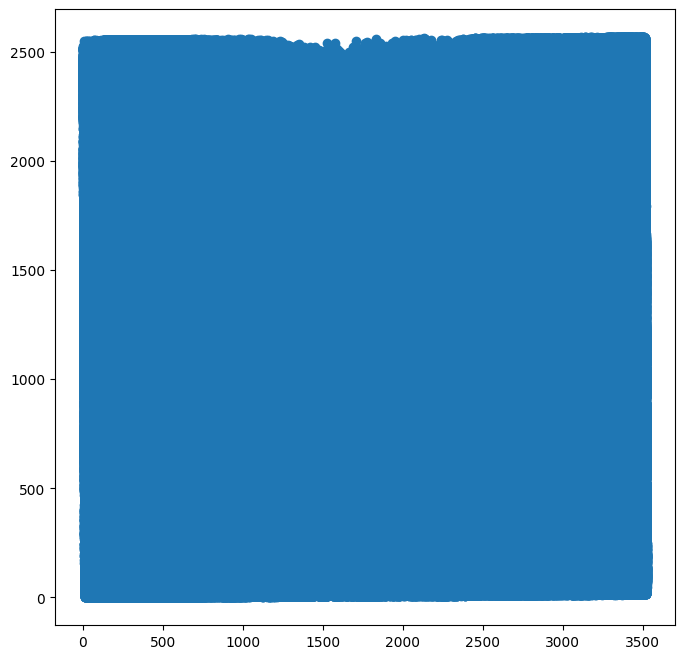

In [177]:
coordinates = adata.obsm['spatial'] * scaling_factor

x = coordinates[:, 0]
y = coordinates[:, 1]
plt.scatter(x,y)